# Import

In [29]:
import torch, os, sys, random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist, imdb

# Hand_sign Dataset

In [3]:
def load_data(folder_path,label,label_int):
    img_list=[]
    folder_list = os.listdir(folder_path)
    for i in range(0,len(folder_list)):
        if label in folder_list[i]:
            files=os.listdir(folder_path+'\\'+folder_list[i])
            for j in range(len(files)):
                img=plt.imread(folder_path+'\\'+folder_list[i]+'\\'+files[j])
                img_list.append(img)
    return img_list, np.full(np.shape(img_list)[0],label_int)

img_list=[]
label_list=[]
for label,label_int in zip(['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y'],list(range(0,24))):
    img_list.append(load_data(r'D:\KDE\homework\빅데이터분석\Train', label,label_int)[0])
    label_list.append(load_data(r'D:\KDE\homework\빅데이터분석\Train', label,label_int)[1])
    
x_train=np.concatenate(img_list)
y_train=np.concatenate(label_list)

img_list=[]
label_list=[]
for label,label_int in zip(['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y'],list(range(0,24))):
    img_list.append(load_data(r'D:\KDE\homework\빅데이터분석\Test', label,label_int)[0])
    label_list.append(load_data(r'D:\KDE\homework\빅데이터분석\Test', label,label_int)[1])
    
x_test=np.concatenate(img_list)
y_test=np.concatenate(label_list)

In [4]:
random.seed(7)
train_idx=list(np.arange(27455))
random.shuffle(train_idx)
x_train=x_train[train_idx]
y_train=y_train[train_idx]

test_idx=list(np.arange(7172))
random.shuffle(test_idx)
x_test=x_test[test_idx]
y_test=y_test[test_idx]

In [378]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [5]:
np.save('x_train',x_train)
np.save('y_train',y_train)
np.save('x_test',x_test)
np.save('y_test',y_test)

In [30]:
x_train = np.load('x_train.npy')/255
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')/255
y_test = np.load('y_test.npy')

In [31]:
x_train = torch.FloatTensor(x_train).unsqueeze(1)
y_train = torch.LongTensor(y_train)
x_test = torch.FloatTensor(x_test).unsqueeze(1)
y_test = torch.LongTensor(y_test)

In [32]:
batch_size=100
dataset = data.TensorDataset(x_train,y_train)
data_loader = data.DataLoader(dataset,batch_size=batch_size,shuffle=False)

# CNN Model

In [33]:
device = 'cuda'
torch.cuda.manual_seed_all(7)

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 24, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [35]:
model = CNN().to(device)

learning_rate=0.001
num_epochs=20
batch_size=100

criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

model.train()
total_loss = 0
total_acc = 0
train_loss = []
train_accuracy = []
i = 0
for epoch in range(num_epochs):
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)
         
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
       
        
        loss.backward()    # calc gradients
       
        total_loss += loss
       
        train_loss.append(total_loss/i)
        optimizer.step()   # update gradients
       
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
       
        total_acc += accuracy
       
        train_accuracy.append(total_acc/i)
       
        if i % 10 == 0:
            print('Epoch: {}\t Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(epoch+1, i, loss, accuracy))
        i += 1
    print('Epoch: {} finished'.format(epoch+1))

총 배치의 수 : 275
Epoch: 1	 Train Step: 0	Loss: 3.180	Accuracy: 5.000
Epoch: 1	 Train Step: 10	Loss: 3.199	Accuracy: 3.000
Epoch: 1	 Train Step: 20	Loss: 3.188	Accuracy: 5.000
Epoch: 1	 Train Step: 30	Loss: 3.106	Accuracy: 13.000
Epoch: 1	 Train Step: 40	Loss: 2.925	Accuracy: 13.000
Epoch: 1	 Train Step: 50	Loss: 2.609	Accuracy: 19.000
Epoch: 1	 Train Step: 60	Loss: 2.634	Accuracy: 20.000
Epoch: 1	 Train Step: 70	Loss: 2.201	Accuracy: 34.000
Epoch: 1	 Train Step: 80	Loss: 1.946	Accuracy: 46.000
Epoch: 1	 Train Step: 90	Loss: 1.578	Accuracy: 46.000
Epoch: 1	 Train Step: 100	Loss: 1.332	Accuracy: 60.000
Epoch: 1	 Train Step: 110	Loss: 1.274	Accuracy: 55.000
Epoch: 1	 Train Step: 120	Loss: 0.954	Accuracy: 73.000
Epoch: 1	 Train Step: 130	Loss: 1.125	Accuracy: 65.000
Epoch: 1	 Train Step: 140	Loss: 0.877	Accuracy: 75.000
Epoch: 1	 Train Step: 150	Loss: 0.982	Accuracy: 68.000
Epoch: 1	 Train Step: 160	Loss: 0.670	Accuracy: 78.000
Epoch: 1	 Train Step: 170	Loss: 0.561	Accuracy: 81.000
Epoch: 1	 

Epoch: 6	 Train Step: 1480	Loss: 0.007	Accuracy: 100.000
Epoch: 6	 Train Step: 1490	Loss: 0.003	Accuracy: 100.000
Epoch: 6	 Train Step: 1500	Loss: 0.034	Accuracy: 99.000
Epoch: 6	 Train Step: 1510	Loss: 0.004	Accuracy: 100.000
Epoch: 6	 Train Step: 1520	Loss: 0.011	Accuracy: 100.000
Epoch: 6	 Train Step: 1530	Loss: 0.003	Accuracy: 100.000
Epoch: 6	 Train Step: 1540	Loss: 0.038	Accuracy: 98.000
Epoch: 6	 Train Step: 1550	Loss: 0.007	Accuracy: 100.000
Epoch: 6	 Train Step: 1560	Loss: 0.004	Accuracy: 100.000
Epoch: 6	 Train Step: 1570	Loss: 0.041	Accuracy: 98.000
Epoch: 6	 Train Step: 1580	Loss: 0.008	Accuracy: 100.000
Epoch: 6	 Train Step: 1590	Loss: 0.003	Accuracy: 100.000
Epoch: 6	 Train Step: 1600	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1610	Loss: 0.003	Accuracy: 100.000
Epoch: 6	 Train Step: 1620	Loss: 0.001	Accuracy: 100.000
Epoch: 6	 Train Step: 1630	Loss: 0.023	Accuracy: 99.000
Epoch: 6	 Train Step: 1640	Loss: 0.001	Accuracy: 100.000
Epoch: 6 finished
Epoch: 7	 Train S

Epoch: 11	 Train Step: 2920	Loss: 0.004	Accuracy: 100.000
Epoch: 11	 Train Step: 2930	Loss: 0.002	Accuracy: 100.000
Epoch: 11	 Train Step: 2940	Loss: 0.003	Accuracy: 100.000
Epoch: 11	 Train Step: 2950	Loss: 0.052	Accuracy: 99.000
Epoch: 11	 Train Step: 2960	Loss: 0.007	Accuracy: 100.000
Epoch: 11	 Train Step: 2970	Loss: 0.046	Accuracy: 99.000
Epoch: 11	 Train Step: 2980	Loss: 0.040	Accuracy: 99.000
Epoch: 11	 Train Step: 2990	Loss: 0.023	Accuracy: 99.000
Epoch: 11	 Train Step: 3000	Loss: 0.046	Accuracy: 99.000
Epoch: 11	 Train Step: 3010	Loss: 0.002	Accuracy: 100.000
Epoch: 11	 Train Step: 3020	Loss: 0.028	Accuracy: 98.000
Epoch: 11 finished
Epoch: 12	 Train Step: 3030	Loss: 0.000	Accuracy: 100.000
Epoch: 12	 Train Step: 3040	Loss: 0.002	Accuracy: 100.000
Epoch: 12	 Train Step: 3050	Loss: 0.003	Accuracy: 100.000
Epoch: 12	 Train Step: 3060	Loss: 0.001	Accuracy: 100.000
Epoch: 12	 Train Step: 3070	Loss: 0.003	Accuracy: 100.000
Epoch: 12	 Train Step: 3080	Loss: 0.001	Accuracy: 100.000
E

Epoch: 16	 Train Step: 4390	Loss: 0.001	Accuracy: 100.000
Epoch: 16 finished
Epoch: 17	 Train Step: 4400	Loss: 0.001	Accuracy: 100.000
Epoch: 17	 Train Step: 4410	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4420	Loss: 0.003	Accuracy: 100.000
Epoch: 17	 Train Step: 4430	Loss: 0.002	Accuracy: 100.000
Epoch: 17	 Train Step: 4440	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4450	Loss: 0.004	Accuracy: 100.000
Epoch: 17	 Train Step: 4460	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4470	Loss: 0.002	Accuracy: 100.000
Epoch: 17	 Train Step: 4480	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4490	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4500	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4510	Loss: 0.005	Accuracy: 100.000
Epoch: 17	 Train Step: 4520	Loss: 0.001	Accuracy: 100.000
Epoch: 17	 Train Step: 4530	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4540	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4550	Loss: 0.002	Accuracy: 100

Text(0.5, 1.0, 'CNN train_loss graph')

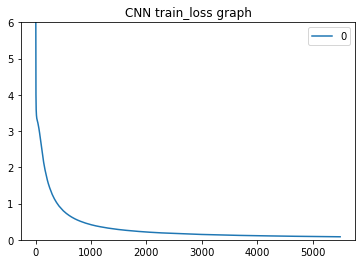

In [36]:
pd.DataFrame(torch.tensor(train_loss).cpu().numpy()).plot()
plt.ylim(0,6)
plt.title('CNN train_loss graph')

In [37]:
with torch.no_grad():
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.936698317527771


# LSTM

In [38]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        
        
    def forward(self, x):        
        rnn_layer = self.lstm
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [40]:
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 24

model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

sequence_length = 28
learning_rate = 0.01
num_epochs = 20
batch_size = 100

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

model.train()
total_loss = 0
total_acc = 0
train_loss = []
train_accuracy = []
i = 0
for epoch in range(num_epochs):
    for data, target in data_loader:
        data = data.reshape(-1, sequence_length, input_size).to(device)
        target = target.to(device)
         
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
       
        
        loss.backward()    # calc gradients
       
        total_loss += loss
       
        train_loss.append(total_loss/i)
        optimizer.step()   # update gradients
       
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
       
        total_acc += accuracy
       
        train_accuracy.append(total_acc/i)
       
        if i % 10 == 0:
            print('Epoch: {}\t Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(epoch+1, i, loss, accuracy))
        i += 1
    print('Epoch: {} finished'.format(epoch+1))

총 배치의 수 : 275
Epoch: 1	 Train Step: 0	Loss: 3.178	Accuracy: 3.000
Epoch: 1	 Train Step: 10	Loss: 3.146	Accuracy: 1.000
Epoch: 1	 Train Step: 20	Loss: 2.996	Accuracy: 11.000
Epoch: 1	 Train Step: 30	Loss: 2.870	Accuracy: 10.000
Epoch: 1	 Train Step: 40	Loss: 2.847	Accuracy: 14.000
Epoch: 1	 Train Step: 50	Loss: 2.612	Accuracy: 17.000
Epoch: 1	 Train Step: 60	Loss: 2.713	Accuracy: 15.000
Epoch: 1	 Train Step: 70	Loss: 2.664	Accuracy: 16.000
Epoch: 1	 Train Step: 80	Loss: 2.454	Accuracy: 24.000
Epoch: 1	 Train Step: 90	Loss: 1.952	Accuracy: 29.000
Epoch: 1	 Train Step: 100	Loss: 1.934	Accuracy: 31.000
Epoch: 1	 Train Step: 110	Loss: 1.867	Accuracy: 34.000
Epoch: 1	 Train Step: 120	Loss: 1.598	Accuracy: 42.000
Epoch: 1	 Train Step: 130	Loss: 1.667	Accuracy: 45.000
Epoch: 1	 Train Step: 140	Loss: 1.700	Accuracy: 40.000
Epoch: 1	 Train Step: 150	Loss: 1.713	Accuracy: 39.000
Epoch: 1	 Train Step: 160	Loss: 1.380	Accuracy: 54.000
Epoch: 1	 Train Step: 170	Loss: 1.471	Accuracy: 49.000
Epoch: 1	

Epoch: 6	 Train Step: 1480	Loss: 0.001	Accuracy: 100.000
Epoch: 6	 Train Step: 1490	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1500	Loss: 0.004	Accuracy: 100.000
Epoch: 6	 Train Step: 1510	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1520	Loss: 0.001	Accuracy: 100.000
Epoch: 6	 Train Step: 1530	Loss: 0.001	Accuracy: 100.000
Epoch: 6	 Train Step: 1540	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1550	Loss: 0.001	Accuracy: 100.000
Epoch: 6	 Train Step: 1560	Loss: 0.001	Accuracy: 100.000
Epoch: 6	 Train Step: 1570	Loss: 0.010	Accuracy: 99.000
Epoch: 6	 Train Step: 1580	Loss: 0.003	Accuracy: 100.000
Epoch: 6	 Train Step: 1590	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1600	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1610	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1620	Loss: 0.001	Accuracy: 100.000
Epoch: 6	 Train Step: 1630	Loss: 0.002	Accuracy: 100.000
Epoch: 6	 Train Step: 1640	Loss: 0.004	Accuracy: 100.000
Epoch: 6 finished
Epoch: 7	 Trai

Epoch: 11	 Train Step: 2930	Loss: 0.001	Accuracy: 100.000
Epoch: 11	 Train Step: 2940	Loss: 0.001	Accuracy: 100.000
Epoch: 11	 Train Step: 2950	Loss: 0.001	Accuracy: 100.000
Epoch: 11	 Train Step: 2960	Loss: 0.000	Accuracy: 100.000
Epoch: 11	 Train Step: 2970	Loss: 0.001	Accuracy: 100.000
Epoch: 11	 Train Step: 2980	Loss: 0.000	Accuracy: 100.000
Epoch: 11	 Train Step: 2990	Loss: 0.000	Accuracy: 100.000
Epoch: 11	 Train Step: 3000	Loss: 0.000	Accuracy: 100.000
Epoch: 11	 Train Step: 3010	Loss: 0.000	Accuracy: 100.000
Epoch: 11	 Train Step: 3020	Loss: 0.001	Accuracy: 100.000
Epoch: 11 finished
Epoch: 12	 Train Step: 3030	Loss: 0.000	Accuracy: 100.000
Epoch: 12	 Train Step: 3040	Loss: 0.000	Accuracy: 100.000
Epoch: 12	 Train Step: 3050	Loss: 0.000	Accuracy: 100.000
Epoch: 12	 Train Step: 3060	Loss: 0.001	Accuracy: 100.000
Epoch: 12	 Train Step: 3070	Loss: 0.000	Accuracy: 100.000
Epoch: 12	 Train Step: 3080	Loss: 0.001	Accuracy: 100.000
Epoch: 12	 Train Step: 3090	Loss: 0.000	Accuracy: 100

Epoch: 16	 Train Step: 4350	Loss: 0.000	Accuracy: 100.000
Epoch: 16	 Train Step: 4360	Loss: 0.000	Accuracy: 100.000
Epoch: 16	 Train Step: 4370	Loss: 0.000	Accuracy: 100.000
Epoch: 16	 Train Step: 4380	Loss: 0.000	Accuracy: 100.000
Epoch: 16	 Train Step: 4390	Loss: 0.000	Accuracy: 100.000
Epoch: 16 finished
Epoch: 17	 Train Step: 4400	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4410	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4420	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4430	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4440	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4450	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4460	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4470	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4480	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4490	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4500	Loss: 0.000	Accuracy: 100.000
Epoch: 17	 Train Step: 4510	Loss: 0.000	Accuracy: 100

Text(0.5, 1.0, 'LSTM train_loss graph')

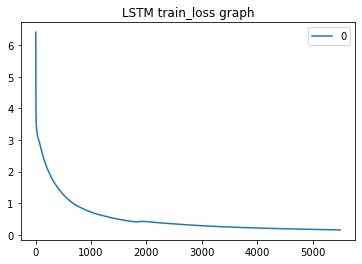

In [41]:
pd.DataFrame(torch.tensor(train_loss).cpu().numpy()).plot()
plt.title('LSTM train_loss graph')

In [42]:
with torch.no_grad():
    x_test = x_test.reshape(-1, sequence_length, input_size).to(device)
    y_test = y_test.to(device)

    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.8381205201148987


# MLP

In [52]:
class MLP(nn.Module):
    def __init__(self, num_class, drop_prob):
        super(MLP, self).__init__()

        self.dropout = nn.Dropout(p=drop_prob)
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 32)
        self.linear4 = nn.Linear(32, num_class)
        self.logsoftmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
       
        x = x.float()
        out = F.relu(self.linear1(x.view(-1, 784)))
        out = self.dropout(out)
        out = F.relu(self.linear2(out))
        out = self.dropout(out)
        out = F.relu(self.linear3(out))
        out = self.dropout(out)
        out = self.linear4(out)

        return self.logsoftmax(out)

In [55]:
model = MLP(24, 0.3).to(device)

learning_rate=0.001
num_epochs=50
batch_size=100


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
total_loss = 0
total_acc = 0
train_loss = []
train_accuracy = []
i = 0
for epoch in range(epochs):
    for data, target in data_loader:
        data, target = Variable(data), Variable(target)
        data = data.to(device)        
        target = target.to(device)
         
        optimizer.zero_grad()
        output = model(data)       
        loss = F.nll_loss(output, target)
        
        loss.backward()
       
        total_loss += loss
       
        train_loss.append(total_loss/i)
        optimizer.step()
       
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
       
        total_acc += accuracy
       
        train_accuracy.append(total_acc/i)
       
        if i % 10 == 0:
            print('Epoch: {}\t Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(epoch+1, i, loss, accuracy))
        i += 1
    print('Epoch: {} finished'.format(epoch+1))

Epoch: 1	 Train Step: 0	Loss: 3.190	Accuracy: 2.000
Epoch: 1	 Train Step: 10	Loss: 3.222	Accuracy: 5.000
Epoch: 1	 Train Step: 20	Loss: 3.186	Accuracy: 4.000
Epoch: 1	 Train Step: 30	Loss: 3.200	Accuracy: 5.000
Epoch: 1	 Train Step: 40	Loss: 3.160	Accuracy: 5.000
Epoch: 1	 Train Step: 50	Loss: 3.156	Accuracy: 10.000
Epoch: 1	 Train Step: 60	Loss: 3.178	Accuracy: 2.000
Epoch: 1	 Train Step: 70	Loss: 3.139	Accuracy: 10.000
Epoch: 1	 Train Step: 80	Loss: 3.160	Accuracy: 7.000
Epoch: 1	 Train Step: 90	Loss: 3.132	Accuracy: 6.000
Epoch: 1	 Train Step: 100	Loss: 3.053	Accuracy: 10.000
Epoch: 1	 Train Step: 110	Loss: 3.025	Accuracy: 8.000
Epoch: 1	 Train Step: 120	Loss: 2.966	Accuracy: 16.000
Epoch: 1	 Train Step: 130	Loss: 2.883	Accuracy: 11.000
Epoch: 1	 Train Step: 140	Loss: 2.889	Accuracy: 10.000
Epoch: 1	 Train Step: 150	Loss: 2.847	Accuracy: 8.000
Epoch: 1	 Train Step: 160	Loss: 2.648	Accuracy: 15.000
Epoch: 1	 Train Step: 170	Loss: 2.624	Accuracy: 19.000
Epoch: 1	 Train Step: 180	Loss:

Epoch: 6	 Train Step: 1500	Loss: 1.497	Accuracy: 44.000
Epoch: 6	 Train Step: 1510	Loss: 1.609	Accuracy: 42.000
Epoch: 6	 Train Step: 1520	Loss: 1.174	Accuracy: 59.000
Epoch: 6	 Train Step: 1530	Loss: 1.367	Accuracy: 56.000
Epoch: 6	 Train Step: 1540	Loss: 1.477	Accuracy: 46.000
Epoch: 6	 Train Step: 1550	Loss: 1.359	Accuracy: 49.000
Epoch: 6	 Train Step: 1560	Loss: 1.230	Accuracy: 54.000
Epoch: 6	 Train Step: 1570	Loss: 1.464	Accuracy: 48.000
Epoch: 6	 Train Step: 1580	Loss: 1.269	Accuracy: 45.000
Epoch: 6	 Train Step: 1590	Loss: 1.203	Accuracy: 61.000
Epoch: 6	 Train Step: 1600	Loss: 1.419	Accuracy: 56.000
Epoch: 6	 Train Step: 1610	Loss: 1.311	Accuracy: 53.000
Epoch: 6	 Train Step: 1620	Loss: 1.251	Accuracy: 59.000
Epoch: 6	 Train Step: 1630	Loss: 1.502	Accuracy: 46.000
Epoch: 6	 Train Step: 1640	Loss: 1.289	Accuracy: 58.000
Epoch: 6 finished
Epoch: 7	 Train Step: 1650	Loss: 1.506	Accuracy: 50.000
Epoch: 7	 Train Step: 1660	Loss: 1.321	Accuracy: 45.000
Epoch: 7	 Train Step: 1670	Los

Epoch: 11	 Train Step: 2960	Loss: 1.195	Accuracy: 59.000
Epoch: 11	 Train Step: 2970	Loss: 1.073	Accuracy: 60.000
Epoch: 11	 Train Step: 2980	Loss: 1.062	Accuracy: 55.000
Epoch: 11	 Train Step: 2990	Loss: 1.144	Accuracy: 59.000
Epoch: 11	 Train Step: 3000	Loss: 1.086	Accuracy: 64.000
Epoch: 11	 Train Step: 3010	Loss: 1.092	Accuracy: 62.000
Epoch: 11	 Train Step: 3020	Loss: 0.846	Accuracy: 67.000
Epoch: 11 finished
Epoch: 12	 Train Step: 3030	Loss: 1.035	Accuracy: 67.000
Epoch: 12	 Train Step: 3040	Loss: 1.157	Accuracy: 60.000
Epoch: 12	 Train Step: 3050	Loss: 1.029	Accuracy: 66.000
Epoch: 12	 Train Step: 3060	Loss: 1.078	Accuracy: 59.000
Epoch: 12	 Train Step: 3070	Loss: 1.043	Accuracy: 60.000
Epoch: 12	 Train Step: 3080	Loss: 1.029	Accuracy: 60.000
Epoch: 12	 Train Step: 3090	Loss: 1.064	Accuracy: 61.000
Epoch: 12	 Train Step: 3100	Loss: 1.092	Accuracy: 67.000
Epoch: 12	 Train Step: 3110	Loss: 0.900	Accuracy: 70.000
Epoch: 12	 Train Step: 3120	Loss: 1.338	Accuracy: 51.000
Epoch: 12	 T

Epoch: 17	 Train Step: 4460	Loss: 1.126	Accuracy: 63.000
Epoch: 17	 Train Step: 4470	Loss: 1.323	Accuracy: 58.000
Epoch: 17	 Train Step: 4480	Loss: 0.945	Accuracy: 67.000
Epoch: 17	 Train Step: 4490	Loss: 0.958	Accuracy: 68.000
Epoch: 17	 Train Step: 4500	Loss: 0.873	Accuracy: 68.000
Epoch: 17	 Train Step: 4510	Loss: 0.871	Accuracy: 69.000
Epoch: 17	 Train Step: 4520	Loss: 0.743	Accuracy: 71.000
Epoch: 17	 Train Step: 4530	Loss: 0.953	Accuracy: 60.000
Epoch: 17	 Train Step: 4540	Loss: 0.850	Accuracy: 68.000
Epoch: 17	 Train Step: 4550	Loss: 1.010	Accuracy: 67.000
Epoch: 17	 Train Step: 4560	Loss: 0.860	Accuracy: 72.000
Epoch: 17	 Train Step: 4570	Loss: 1.077	Accuracy: 67.000
Epoch: 17	 Train Step: 4580	Loss: 0.809	Accuracy: 67.000
Epoch: 17	 Train Step: 4590	Loss: 0.815	Accuracy: 74.000
Epoch: 17	 Train Step: 4600	Loss: 0.838	Accuracy: 73.000
Epoch: 17	 Train Step: 4610	Loss: 0.753	Accuracy: 74.000
Epoch: 17	 Train Step: 4620	Loss: 0.969	Accuracy: 67.000
Epoch: 17	 Train Step: 4630	Los

Epoch: 22	 Train Step: 5920	Loss: 0.855	Accuracy: 74.000
Epoch: 22	 Train Step: 5930	Loss: 0.669	Accuracy: 76.000
Epoch: 22	 Train Step: 5940	Loss: 0.952	Accuracy: 72.000
Epoch: 22	 Train Step: 5950	Loss: 0.693	Accuracy: 74.000
Epoch: 22	 Train Step: 5960	Loss: 0.564	Accuracy: 82.000
Epoch: 22	 Train Step: 5970	Loss: 0.903	Accuracy: 67.000
Epoch: 22	 Train Step: 5980	Loss: 0.751	Accuracy: 74.000
Epoch: 22	 Train Step: 5990	Loss: 0.809	Accuracy: 72.000
Epoch: 22	 Train Step: 6000	Loss: 0.715	Accuracy: 75.000
Epoch: 22	 Train Step: 6010	Loss: 0.695	Accuracy: 76.000
Epoch: 22	 Train Step: 6020	Loss: 0.701	Accuracy: 79.000
Epoch: 22	 Train Step: 6030	Loss: 0.884	Accuracy: 69.000
Epoch: 22	 Train Step: 6040	Loss: 0.658	Accuracy: 75.000
Epoch: 22 finished
Epoch: 23	 Train Step: 6050	Loss: 0.860	Accuracy: 72.000
Epoch: 23	 Train Step: 6060	Loss: 0.959	Accuracy: 65.000
Epoch: 23	 Train Step: 6070	Loss: 0.908	Accuracy: 72.000
Epoch: 23	 Train Step: 6080	Loss: 0.817	Accuracy: 72.000
Epoch: 23	 T

Epoch: 27	 Train Step: 7350	Loss: 0.900	Accuracy: 79.000
Epoch: 27	 Train Step: 7360	Loss: 0.977	Accuracy: 73.000
Epoch: 27	 Train Step: 7370	Loss: 1.105	Accuracy: 69.000
Epoch: 27	 Train Step: 7380	Loss: 0.875	Accuracy: 73.000
Epoch: 27	 Train Step: 7390	Loss: 0.884	Accuracy: 69.000
Epoch: 27	 Train Step: 7400	Loss: 0.731	Accuracy: 82.000
Epoch: 27	 Train Step: 7410	Loss: 0.621	Accuracy: 78.000
Epoch: 27	 Train Step: 7420	Loss: 0.770	Accuracy: 75.000
Epoch: 27 finished
Epoch: 28	 Train Step: 7430	Loss: 0.618	Accuracy: 77.000
Epoch: 28	 Train Step: 7440	Loss: 0.803	Accuracy: 75.000
Epoch: 28	 Train Step: 7450	Loss: 0.858	Accuracy: 70.000
Epoch: 28	 Train Step: 7460	Loss: 0.673	Accuracy: 82.000
Epoch: 28	 Train Step: 7470	Loss: 0.657	Accuracy: 76.000
Epoch: 28	 Train Step: 7480	Loss: 0.601	Accuracy: 78.000
Epoch: 28	 Train Step: 7490	Loss: 0.636	Accuracy: 78.000
Epoch: 28	 Train Step: 7500	Loss: 0.790	Accuracy: 72.000
Epoch: 28	 Train Step: 7510	Loss: 0.749	Accuracy: 77.000
Epoch: 28	 T

Epoch: 32 finished
Epoch: 33	 Train Step: 8800	Loss: 0.581	Accuracy: 82.000
Epoch: 33	 Train Step: 8810	Loss: 0.592	Accuracy: 78.000
Epoch: 33	 Train Step: 8820	Loss: 0.781	Accuracy: 78.000
Epoch: 33	 Train Step: 8830	Loss: 0.531	Accuracy: 82.000
Epoch: 33	 Train Step: 8840	Loss: 0.468	Accuracy: 83.000
Epoch: 33	 Train Step: 8850	Loss: 0.538	Accuracy: 79.000
Epoch: 33	 Train Step: 8860	Loss: 1.001	Accuracy: 70.000
Epoch: 33	 Train Step: 8870	Loss: 0.604	Accuracy: 79.000
Epoch: 33	 Train Step: 8880	Loss: 0.742	Accuracy: 74.000
Epoch: 33	 Train Step: 8890	Loss: 0.830	Accuracy: 70.000
Epoch: 33	 Train Step: 8900	Loss: 0.603	Accuracy: 78.000
Epoch: 33	 Train Step: 8910	Loss: 0.739	Accuracy: 73.000
Epoch: 33	 Train Step: 8920	Loss: 0.570	Accuracy: 82.000
Epoch: 33	 Train Step: 8930	Loss: 0.822	Accuracy: 75.000
Epoch: 33	 Train Step: 8940	Loss: 0.587	Accuracy: 78.000
Epoch: 33	 Train Step: 8950	Loss: 0.689	Accuracy: 78.000
Epoch: 33	 Train Step: 8960	Loss: 0.591	Accuracy: 78.000
Epoch: 33	 T

Epoch: 38	 Train Step: 10250	Loss: 0.483	Accuracy: 85.000
Epoch: 38	 Train Step: 10260	Loss: 0.427	Accuracy: 86.000
Epoch: 38	 Train Step: 10270	Loss: 0.848	Accuracy: 70.000
Epoch: 38	 Train Step: 10280	Loss: 0.462	Accuracy: 85.000
Epoch: 38	 Train Step: 10290	Loss: 0.597	Accuracy: 81.000
Epoch: 38	 Train Step: 10300	Loss: 0.618	Accuracy: 77.000
Epoch: 38	 Train Step: 10310	Loss: 0.591	Accuracy: 79.000
Epoch: 38	 Train Step: 10320	Loss: 0.515	Accuracy: 84.000
Epoch: 38	 Train Step: 10330	Loss: 0.613	Accuracy: 86.000
Epoch: 38	 Train Step: 10340	Loss: 0.482	Accuracy: 81.000
Epoch: 38	 Train Step: 10350	Loss: 0.503	Accuracy: 82.000
Epoch: 38	 Train Step: 10360	Loss: 0.445	Accuracy: 86.000
Epoch: 38	 Train Step: 10370	Loss: 0.549	Accuracy: 80.000
Epoch: 38	 Train Step: 10380	Loss: 0.512	Accuracy: 85.000
Epoch: 38	 Train Step: 10390	Loss: 0.738	Accuracy: 77.000
Epoch: 38	 Train Step: 10400	Loss: 0.635	Accuracy: 78.000
Epoch: 38	 Train Step: 10410	Loss: 0.532	Accuracy: 80.000
Epoch: 38	 Tra

Epoch: 43	 Train Step: 11670	Loss: 0.532	Accuracy: 82.000
Epoch: 43	 Train Step: 11680	Loss: 0.462	Accuracy: 82.000
Epoch: 43	 Train Step: 11690	Loss: 0.561	Accuracy: 82.000
Epoch: 43	 Train Step: 11700	Loss: 0.684	Accuracy: 77.000
Epoch: 43	 Train Step: 11710	Loss: 0.516	Accuracy: 85.000
Epoch: 43	 Train Step: 11720	Loss: 0.429	Accuracy: 86.000
Epoch: 43	 Train Step: 11730	Loss: 0.487	Accuracy: 87.000
Epoch: 43	 Train Step: 11740	Loss: 0.458	Accuracy: 82.000
Epoch: 43	 Train Step: 11750	Loss: 0.503	Accuracy: 79.000
Epoch: 43	 Train Step: 11760	Loss: 0.655	Accuracy: 81.000
Epoch: 43	 Train Step: 11770	Loss: 0.641	Accuracy: 76.000
Epoch: 43	 Train Step: 11780	Loss: 0.621	Accuracy: 77.000
Epoch: 43	 Train Step: 11790	Loss: 0.707	Accuracy: 83.000
Epoch: 43	 Train Step: 11800	Loss: 0.488	Accuracy: 87.000
Epoch: 43	 Train Step: 11810	Loss: 0.526	Accuracy: 80.000
Epoch: 43	 Train Step: 11820	Loss: 0.685	Accuracy: 79.000
Epoch: 43 finished
Epoch: 44	 Train Step: 11830	Loss: 0.820	Accuracy: 76

Epoch: 48	 Train Step: 13090	Loss: 0.468	Accuracy: 85.000
Epoch: 48	 Train Step: 13100	Loss: 0.490	Accuracy: 85.000
Epoch: 48	 Train Step: 13110	Loss: 0.468	Accuracy: 84.000
Epoch: 48	 Train Step: 13120	Loss: 0.636	Accuracy: 76.000
Epoch: 48	 Train Step: 13130	Loss: 0.610	Accuracy: 70.000
Epoch: 48	 Train Step: 13140	Loss: 0.596	Accuracy: 80.000
Epoch: 48	 Train Step: 13150	Loss: 0.788	Accuracy: 80.000
Epoch: 48	 Train Step: 13160	Loss: 0.607	Accuracy: 80.000
Epoch: 48	 Train Step: 13170	Loss: 0.412	Accuracy: 87.000
Epoch: 48	 Train Step: 13180	Loss: 0.517	Accuracy: 82.000
Epoch: 48	 Train Step: 13190	Loss: 0.465	Accuracy: 81.000
Epoch: 48 finished
Epoch: 49	 Train Step: 13200	Loss: 0.555	Accuracy: 84.000
Epoch: 49	 Train Step: 13210	Loss: 0.643	Accuracy: 83.000
Epoch: 49	 Train Step: 13220	Loss: 0.556	Accuracy: 83.000
Epoch: 49	 Train Step: 13230	Loss: 0.667	Accuracy: 77.000
Epoch: 49	 Train Step: 13240	Loss: 0.494	Accuracy: 84.000
Epoch: 49	 Train Step: 13250	Loss: 0.484	Accuracy: 81

Text(0.5, 1.0, 'MLP train_loss graph')

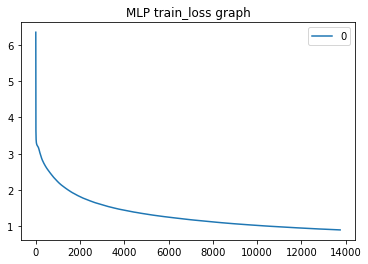

In [56]:
pd.DataFrame(torch.tensor(train_loss).cpu().numpy()).plot()
plt.title('MLP train_loss graph')

In [58]:
correct=0
with torch.no_grad():
    x_test = Variable(x_test).to(device)
    y_test = Variable(y_test).to(device)

    prediction = model(x_test).data.max(1)[1]
    correct += prediction.eq(y_test).sum()
    accuracy = correct /len(y_test)
    print('Accuracy:', accuracy.item())

Accuracy: 0.6153095364570618
